In [2]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

# plotting the car
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import scipy.misc
from scipy import ndimage

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

%matplotlib inline

# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

In [3]:
X = cas.MX.sym('X')
Y = cas.MX.sym('Y')
Phi = cas.MX.sym('Phi')
Delta = cas.MX.sym('Delta')
V = cas.MX.sym('V')
s = cas.MX.sym('s')

delta_u = cas.MX.sym('delta_u')
v_u = cas.MX.sym('v_u')
x = cas.vertcat(X, Y, Phi, Delta, V, s)
u = cas.vertcat(delta_u, v_u)

L = 1.0
ode = cas.vertcat(V * cas.cos(Phi),
                V * cas.sin(Phi),
                V * cas.tan(Delta) / L,
                delta_u,
                v_u,
                V)

f = cas.Function('f',[x,u],[ode],['x','u'],['ode'])

# Discrete (integrated) dynamics $\vec{x}_{t+1} = F(\vec{x}_{t}, \vec{u}_{t})$

In [4]:

intg_options = {}
intg_options['tf'] = dt # from dt
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 6  #from 4

dae = {}  #What's a DAE?
dae['x'] = x
dae['p'] = u
dae['ode'] = f(x,u)
intg = cas.integrator('intg','rk', dae, intg_options)
res = intg(x0=x,p=u)
x_next = res['xf']
F = cas.Function('F',[x,u],[x_next],['x','u'],['x_next'])

NameError: name 'dt' is not defined

# Car class (for plotting)

In [5]:
class Car:
    def __init__(self):
        self.L = 1.0 # m
        
    def get_frame(self, x, ax=None, amb=False):
    
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        else:
            fig = ax.get_figure()
            
            
        X, Y, Phi, Delta, V, S = x.flatten()
        if not amb:
            arr_img = plt.imread('red_car.png', format='png')
        else:
            arr_img = plt.imread('ambulance.png', format='png')
        degree = np.rad2deg(Phi)
        xy = (X, Y)
        rotated_img = ndimage.rotate(arr_img, degree)
        ax.axis('square')
        window_width = 12
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        
        if not amb:
            imagebox = OffsetImage(rotated_img, zoom=self.L * 1/(2*window_width)) #this zoom is to scale L=1
        else:
            imagebox = OffsetImage(rotated_img, zoom=1/3*self.L * 1/(2*window_width)) #this zoom is to scale L=1            
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, (X, Y),frameon=False)
        ax.add_artist(ab)        

        return fig, ax        

# Parameterization of Desired Trajectory ($\vec{x}_d = f_d(s)$)

In [6]:
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)

fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

## Optimization

In [7]:
ego_car = Car()
folder = "results/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)


min_dist = 2 * (2 * .5**2)**.5

# Initial Conditions
x0 = np.array([1.5*min_dist, .5, 0, 0, 1.0, 0]).T
x0_2 = np.array([1.5*min_dist,-.61, .0, 0, 1.0,0]).T
x0_amb = np.array([0, 0.0, 0, 0, 2.5,0]).T

n_cars = 3

# Generating Cost Matrices
q_lon, q_lat, q_phi, q_v, = 1., 5.0, 5.0, 10.0,  #State costs
r_delta, r_vdot = 10.0, 10.0  #Control input costs

Q_k = np.eye(6)
Q_k[0,0] = q_lon
Q_k[1,1] = q_lat
Q_k[2,2] = q_phi
Q_k[3,3] = 0
Q_k[4,4] = q_v
Q_k[5,5] = q_lon
# C[6,6] = r_delta
# C[7,7] = r_vdot
Q_k[0,5] = -q_lon
Q_k[5,0] = -q_lon
R_k = np.eye(2)

# n_mpc = int(20 / dt) #number of times we will run the MPC
n_mpc = 1 
for i_mpc in range(n_mpc):
#     opti = cas.Opti()
    opti = cas.Opti()

    T = opti.variable() #numbr of time horizons
    N = 100 #Number of control intervals
    dt = T/N

    n_ctrl = 2
    n_state = 6

    x_opt = opti.variable(n_state, N+1) # initialize X for each car that we will optimize
    x2_opt = opti.variable(n_state, N+1)
    xamb_opt = opti.variable(n_state, N+1)

    u_opt = opti.variable(n_ctrl, N)
    u2_opt = opti.variable(n_ctrl, N)
    uamb_opt = opti.variable(n_ctrl, N)

    p = opti.parameter(n_state, 1) #this will be the initial state
    p2 = opti.parameter(n_state, 1)
    pamb = opti.parameter(n_state, 1)


    x_desired = opti.variable(3, N+1)
    x2_desired = opti.variable(3, N+1)
    xamb_desired = opti.variable(3, N+1)


    
    car1_costs = (np.sum([cas.transpose(u_opt[:,k]) @ R_k @ u_opt[:,k] for k in range(N)]) + 
        np.sum([(-cas.sin(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
                cas.cos(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
               for k in range(N+1)]) +
        cas.sumsqr(x_desired[2,:]-x_opt[2,:]))
    
    car2_costs = (np.sum([cas.transpose(u2_opt[:,k]) @ R_k @ u2_opt[:,k] for k in range(N)]) + 
        np.sum([(-cas.sin(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
                cas.cos(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
               for k in range(N+1)]) +
        cas.sumsqr(x2_desired[2,:]-x2_opt[2,:]))      
    
    amb_costs = (np.sum([cas.transpose(uamb_opt[:,k]) @ R_k @ uamb_opt[:,k] for k in range(N)]) + 
        np.sum([(-cas.sin(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
                cas.cos(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
               for k in range(N+1)]) +
        cas.sumsqr(xamb_desired[2,:]-xamb_opt[2,:])  + 100 * T)    
    # somewhat like LQR
    opti.subject_to(opti.bounded(0, T, 10))
    slack1 = opti.variable(1, N+1)
    slack2 = opti.variable(1, N+1)
    slack3 = opti.variable(1, N+1)
    slack_cost = cas.sumsqr(slack1) + cas.sumsqr(slack2) + cas.sumsqr(slack3)
    
#     opti.minimize( car1_costs + car2_costs + amb_costs + 1000 * slack_cost)
    opti.minimize(0.1 * car1_costs + 0.1 * car2_costs + 3*amb_costs + 100*slack_cost)
    opti.subject_to( slack1 >= 0)
    opti.subject_to( slack2 >= 0)
    opti.subject_to( slack3 >= 0)

    
    
    
    for k in range(N):
        k1 = f(x_opt[:,k],         u_opt[:,k])
        k2 = f(x_opt[:,k]+dt/2*k1, u_opt[:,k])
        k3 = f(x_opt[:,k]+dt/2*k2, u_opt[:,k])
        k4 = f(x_opt[:,k]+dt*k3,   u_opt[:,k])
        x_next = x_opt[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(x_opt[:,k+1] == x_next)


        k1 = f(x2_opt[:,k],         u2_opt[:,k])
        k2 = f(x2_opt[:,k]+dt/2*k1, u2_opt[:,k])
        k3 = f(x2_opt[:,k]+dt/2*k2, u2_opt[:,k])
        k4 = f(x2_opt[:,k]+dt*k3,   u2_opt[:,k])
        x_next = x2_opt[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(x2_opt[:,k+1] == x_next)


        k1 = f(xamb_opt[:,k],         uamb_opt[:,k])
        k2 = f(xamb_opt[:,k]+dt/2*k1, uamb_opt[:,k])
        k3 = f(xamb_opt[:,k]+dt/2*k2, uamb_opt[:,k])
        k4 = f(xamb_opt[:,k]+dt*k3,   uamb_opt[:,k])
        x_next = xamb_opt[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(xamb_opt[:,k+1] == x_next)    

    
    #constraints
    
#     for k in range(N):
#         opti.subject_to( x_opt[:, k+1] == F(x_opt[:, k], u_opt[:, k]))

    for k in range(N+1):
        opti.subject_to( x_desired[:, k] == fd(x_opt[-1, k]) ) #This should be the trajectory dynamic constraint        
        
        
    opti.subject_to(opti.bounded(-np.pi/4, u_opt[0,:], np.pi/4))
    opti.subject_to(opti.bounded(-50, u_opt[1,:], 50))
    v_max = 10
    opti.subject_to(opti.bounded(0, x_opt[4,:],v_max))    
    opti.subject_to(x_opt[:,0] == p)
    
    #Just repeat constraints for x2
#     for k in range(N):
#         opti.subject_to( x2_opt[:, k+1] == F(x2_opt[:, k], u2_opt[:, k]))
    for k in range(N+1):
        opti.subject_to( x2_desired[:, k] == fd(x2_opt[-1, k]) ) #This should be the trajectory dynamic constraint             
    
    
    opti.subject_to(opti.bounded(-np.pi/4, u2_opt[0,:], np.pi/4))
    opti.subject_to(opti.bounded(-1, u2_opt[1,:], 1))
    v_max = 5
    opti.subject_to(opti.bounded(0, x2_opt[4,:],v_max))    
    opti.subject_to(x2_opt[:,0] == p2)
    
    #ambulance
#     for k in range(N):
#         opti.subject_to( xamb_opt[:, k+1] == F(xamb_opt[:, k], uamb_opt[:, k]))
    for k in range(N+1):
        opti.subject_to( xamb_desired[:, k] == fd(xamb_opt[-1, k]) ) #This should be the trajectory dynamic constraint             
    
    
    opti.subject_to(opti.bounded(-np.pi/4, uamb_opt[0,:], np.pi/4))
    opti.subject_to(opti.bounded(-1, uamb_opt[1,:], 1))
    v_max = 20
    opti.subject_to(opti.bounded(0, xamb_opt[4,:],v_max))    
    opti.subject_to(xamb_opt[:,0] == pamb)    
    
#     min_dist = 0.0001
    for k in range(N+1):
        opti.subject_to( cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]) > min_dist**2 - slack1)
        opti.subject_to( cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 -slack2)
        opti.subject_to( cas.sumsqr(x2_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 -slack3)
    
    # constraints to help out
    opti.subject_to( opti.bounded(-1, x_opt[0,:], 30) )
    opti.subject_to( opti.bounded(-1, x2_opt[0,:], 30) )
    opti.subject_to( opti.bounded(-1, xamb_opt[0,:], 30) )
    opti.subject_to( opti.bounded(-10, x_opt[1,:], 10) )
    opti.subject_to( opti.bounded(-10, x2_opt[1,:], 10) )
    opti.subject_to( opti.bounded(-10, xamb_opt[1,:], 10) )
    
    opti.subject_to( xamb_opt[0,-1] > 12)
    
    opti.solver('ipopt',{'warn_initial_bounds':True},{"max_iter":300})
    
    opti.set_value(p,x0)
    opti.set_value(p2,x0_2)
    opti.set_value(pamb,x0_amb)
    
    sol = opti.solve()
    
    x_mpc = sol.value(x_opt)
    u_mpc = sol.value(u_opt)

    x2_mpc = sol.value(x2_opt)
    u2_mpc = sol.value(u2_opt)
        
    x0 = x_mpc[:,1:2]
    x0_2 = x2_mpc[:,1:2]
    
    x_des = sol.value(x_desired)
    x2_des = sol.value(x2_desired)  
    
    xamb_mpc = sol.value(xamb_opt)
    
    PLOT_LIVE = False
    if PLOT_LIVE:
        fig, ax = ego_car.get_frame(x0[:,0])
        fig, ax = ego_car.get_frame(x0_2[:,0], ax)
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(i_mpc))
        plt.close(fig)     

results/20200203-154351/

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    12030
Number of nonzeros in inequality constraint Jacobian.:   154829
Number of nonzeros in Lagrangian Hessian.............:    11761

Total number of variables............................:     3631
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:     

  78  9.5003503e+03 8.51e+00 1.88e+04  -1.0 7.80e+02    -  7.82e-04 1.10e-03f  1
  79  9.5056818e+03 8.50e+00 1.88e+04  -1.0 7.99e+02    -  7.35e-04 1.27e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  9.5285384e+03 8.49e+00 1.88e+04  -1.0 5.32e+02    -  5.23e-04 1.13e-03f  1
  81  9.5607236e+03 8.49e+00 1.87e+04  -1.0 5.84e+02    -  2.00e-03 7.39e-04f  1
  82  9.5936995e+03 8.47e+00 1.88e+04  -1.0 5.79e+02    -  5.68e-04 1.72e-03f  1
  83  9.6200624e+03 8.46e+00 1.87e+04  -1.0 6.18e+02    -  1.32e-03 1.42e-03f  1
  84  9.6390256e+03 8.45e+00 1.88e+04  -1.0 6.80e+02    -  3.05e-04 9.37e-04f  1
  85  9.6603352e+03 8.45e+00 1.87e+04  -1.0 8.05e+02    -  8.06e-04 7.79e-04f  1
  86  9.7081842e+03 8.43e+00 1.88e+04  -1.0 7.75e+02    -  6.90e-04 1.36e-03f  1
  87  9.7216626e+03 8.43e+00 1.88e+04  -1.0 1.19e+03    -  1.51e-04 3.77e-04f  1
  88  9.7652275e+03 8.42e+00 1.88e+04  -1.0 1.40e+03    -  5.54e-04 9.41e-04f  1
  89  9.7919692e+03 8.42e+00

 173  2.7557161e+04 3.46e+00 6.54e+01  -1.0 3.07e+00   0.0 1.22e-01 5.62e-02f  1
 174  2.7547860e+04 3.46e+00 6.54e+01  -1.0 2.62e+00   0.4 8.03e-02 6.36e-04f  1
 175  2.4703783e+04 2.98e+00 7.09e+01  -1.0 1.97e+01  -0.0 4.68e-02 1.40e-01f  1
 176  2.3076670e+04 2.77e+00 5.25e+01  -1.0 7.04e+00  -0.5 1.89e-01 6.82e-02f  1
 177  2.1023050e+04 2.42e+00 6.12e+01  -1.0 2.89e+00  -0.1 8.12e-02 1.26e-01f  1
 178  1.8411429e+04 2.08e+00 5.30e+01  -1.0 6.84e+00  -0.6 1.65e-01 1.42e-01f  1
 179  1.6157145e+04 1.66e+00 4.38e+01  -1.0 2.47e+00  -0.1 1.90e-01 2.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.4712341e+04 1.29e+00 2.47e+01  -1.0 1.66e+00   0.3 2.87e-01 2.27e-01f  1
 181  1.3056680e+04 9.82e-01 2.64e+01  -1.0 2.19e+00  -0.2 3.89e-01 2.36e-01f  1
 182  1.1872415e+04 6.57e-01 5.97e+01  -1.0 9.83e-01   0.2 9.95e-01 3.31e-01f  1
 183  1.0184287e+04 3.21e-01 3.49e+01  -1.0 1.80e+00  -0.2 4.37e-01 5.11e-01f  1
 184  9.3874557e+03 4.96e-02

 268  1.0554948e+04 9.07e-01 4.13e+02  -2.5 4.26e-01  -0.8 8.02e-01 3.82e-01h  1
 269  1.0554373e+04 6.94e-01 1.12e+03  -2.5 4.11e-01   0.5 8.23e-01 5.27e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.0554320e+04 3.18e+00 7.93e+03  -2.5 4.14e-01   1.0 1.00e+00 8.17e-01h  1
 271  1.0554874e+04 2.10e+00 1.99e+02  -2.5 3.76e-01   1.4 6.23e-01 1.00e+00h  1
 272  1.0555016e+04 1.84e+00 3.30e+02  -2.5 1.42e-01   1.8 3.52e-01 1.47e-01h  1
 273  1.0555381e+04 1.45e+00 6.88e+02  -2.5 1.73e-01   1.3 1.00e+00 2.90e-01h  2
 274  1.0555479e+04 1.42e+00 6.76e+02  -2.5 3.30e+00   0.9 2.34e-01 2.44e-02h  3
 275  1.0555571e+04 1.28e+00 6.29e+02  -2.5 1.11e-01   1.3 1.00e+00 1.15e-01h  4
 276  1.0555630e+04 1.20e+00 5.95e+02  -2.5 2.38e-01   0.8 1.00e+00 6.42e-02h  4
 277  1.0555635e+04 1.20e+00 5.93e+02  -2.5 8.75e-01   0.3 3.34e-01 3.82e-03h  6
 278  1.0555645e+04 1.19e+00 5.90e+02  -2.5 7.47e+00  -0.2 2.73e-03 4.36e-03h  3
 279  1.0555657e+04 1.19e+00

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [ ]:
opti.set_initial(opti.debug.value_variables())
sol = opti.solve()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    12030
Number of nonzeros in inequality constraint Jacobian.:   154829
Number of nonzeros in Lagrangian Hessian.............:    11761

Total number of variables............................:     3631
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2727
Total number of inequality constraints...............:    32417
        inequality constraints with only lower bounds:      304
   inequality constraints with lower and upper bounds:     1510
        inequality constraints with only upper bounds:    30603

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  83  1.0999307e+04 1.85e-02 9.48e+00  -1.0 5.14e-02  -0.1 1.00e+00 1.00e+00h  1
  84  1.0999343e+04 2.53e-03 9.65e-01  -1.0 7.17e-03   1.2 1.00e+00 1.00e+00h  1
  85  1.0947887e+04 8.01e-01 9.89e+02  -1.7 1.44e-01   0.8 9.42e-01 1.00e+00f  1
  86  1.0947594e+04 8.12e-01 9.14e+02  -1.7 5.31e+00   0.3 5.91e-02 2.62e-02h  4
  87  1.0945429e+04 7.92e-01 7.52e+02  -1.7 9.14e-01   0.7 3.62e-01 2.60e-01h  2
  88  1.0945819e+04 7.79e-01 6.53e+02  -1.7 1.90e+00   1.1 5.07e-01 6.65e-02h  2
  89  1.0945828e+04 7.78e-01 6.52e+02  -1.7 1.42e+00   1.6 7.11e-01 1.05e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.0945829e+04 7.77e-01 6.52e+02  -1.7 2.73e-01   2.0 1.00e+00 1.19e-03h 10
  91  1.0945830e+04 7.77e-01 6.51e+02  -1.7 1.49e+00   1.5 6.32e-01 9.52e-05h 13
  92  1.0945830e+04 7.77e-01 6.51e+02  -1.7 3.00e-01   1.9 1.00e+00 2.44e-04h 13
  93  1.0945830e+04 7.77e-01 6.51e+02  -1.7 2.00e+00   1.5 4.42e-01 2.22e-05h 15
  94  1.0946872e+04 7.05e-01

 176  1.0913428e+04 3.71e-01 8.76e+03  -1.7 2.36e-01   2.5 7.20e-02 4.09e-02h  1
 177  1.0913541e+04 3.43e-01 1.83e+04  -1.7 2.59e-01   2.9 4.67e-02 9.04e-02h  1
 178  1.0913531e+04 3.39e-01 2.21e+04  -1.7 3.38e-01   3.4 2.55e-01 1.01e-02h  1
 179  1.0913467e+04 3.21e-01 1.92e+04  -1.7 5.22e-01   2.9 1.73e-01 5.35e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.0913282e+04 3.02e-01 1.77e+04  -1.7 5.28e-01   2.4 1.30e-01 6.08e-02f  1
 181  1.0912921e+04 2.55e-01 1.44e+04  -1.7 3.78e-01   1.9 1.00e+00 1.53e-01f  1
 182  1.0911937e+04 4.03e-01 7.27e+03  -1.7 3.12e-01   1.4 1.81e-01 5.24e-01F  1
 183  1.0911946e+04 4.01e-01 9.94e+03  -1.7 3.42e-01   2.8 4.23e-01 4.45e-03h  1
 184  1.0912071e+04 3.86e-01 9.51e+03  -1.7 4.96e-01   2.3 1.73e-01 3.89e-02h  1
 185  1.0913782e+04 2.70e-01 5.12e+03  -1.7 5.01e-01   1.8 1.00e+00 3.01e-01h  1
 186  1.0920555e+04 2.20e-01 1.41e+03  -1.7 3.48e-01   1.3 3.24e-01 8.01e-01h  1
 187  1.0920206e+04 2.02e-01

 269  1.0389987e+04 5.93e-02 1.39e+03  -2.5 4.68e+01  -4.8 1.14e-01 1.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.0381261e+04 6.32e-02 1.40e+03  -2.5 4.75e+02  -5.3 1.77e-02 9.35e-03f  1
 271  1.0347719e+04 1.97e-01 1.53e+03  -2.5 3.10e+01  -4.9 2.53e-02 1.65e-01f  1
 272  1.0345273e+04 1.35e-01 1.20e+03  -2.5 9.68e-02   0.9 2.40e-01 4.19e-01h  1
 273  1.0345041e+04 1.27e-01 9.27e+02  -2.5 2.52e-01   1.4 6.47e-02 2.32e-01h  1
 274  1.0344911e+04 1.33e-01 9.39e+02  -2.5 1.42e+01   0.9 2.35e-03 2.55e-03h  1
 275  1.0344308e+04 1.27e-01 7.85e+02  -2.5 1.82e-01   1.3 1.45e-01 2.05e-01h  1
 276  1.0344303e+04 1.27e-01 7.82e+02  -2.5 5.61e-02   3.6 2.44e-02 3.38e-03h  1
 277  1.0344318e+04 1.20e-01 6.85e+02  -2.5 6.59e-02   3.1 6.76e-03 1.43e-01h  1
 278  1.0344270e+04 8.54e-02 5.57e+02  -2.5 6.44e-02   2.6 4.41e-02 1.79e-01h  1
 279  1.0344254e+04 8.00e-02 5.33e+02  -2.5 4.94e-02   3.0 6.21e-01 4.15e-02h  1
iter    objective    inf_pr 

In [ ]:
plt.plot(opti.debug.value(x_opt)[0,:],opti.debug.value(x_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[0,:],opti.debug.value(x2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[0,:],opti.debug.value(xamb_opt)[1,:],'o',c='r')
plt.show()

Text(0, 0.5, 'dist')

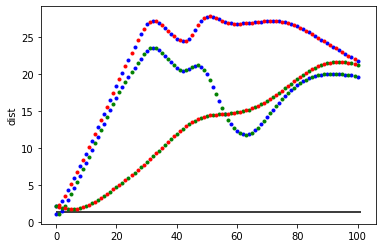

In [9]:
plt.plot([k for k in range(opti.debug.value(x_opt).shape[1]) if k%2==0], 
         [np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%2==0],
         '.',c='b')

plt.plot([k for k in range(opti.debug.value(x_opt).shape[1]) if k%2!=0], 
         [np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%2!=0],
         '.',c='g')


plt.plot([k for k in range(opti.debug.value(x_opt).shape[1]) if k%2==0], 
         [np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%2==0],
         '.',c='b')

plt.plot([k for k in range(opti.debug.value(x_opt).shape[1]) if k%2!=0], 
         [np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%2!=0],
         '.',c='r')

plt.plot([k for k in range(opti.debug.value(x_opt).shape[1]) if k%2==0], 
         [np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%2==0],
         '.',c='g')

plt.plot([k for k in range(opti.debug.value(x_opt).shape[1]) if k%2!=0], 
         [np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%2!=0],
         '.',c='r')




# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%3==0],'.',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%3!=0],'.',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%3==0],'.',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1]) if k%3!=0],'.',c='r')

plt.hlines(min_dist,0,opti.debug.value(x_opt).shape[1])
plt.ylabel('dist')
# plt.ylim([.7,.71])

Text(0, 0.5, 'slack')

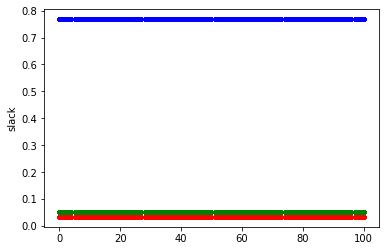

In [10]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [11]:
opti.debug.value(T)

9.999991690936762

In [12]:
x_mpc = opti.debug.value(x_opt)
x2_mpc = opti.debug.value(x2_opt)
xamb_mpc = opti.debug.value(xamb_opt)
x_des = opti.value(x_desired)
x2_des = opti.value(x2_desired)  
PLOT_LIVE = False

In [13]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
plt.plot([opti.debug.value(x_opt[5,k]) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(x2_opt[5,k]) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(xamb_opt[5,k]) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')
plt.ylabel('V')
plt.xlabel('k')
plt.show()

In [ ]:
vid_fname = folder + 'car.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
for k in range(N+1):
    fig, ax = ego_car.get_frame(opti.debug.value(x_opt)[:,k])
    fig, ax = ego_car.get_frame(opti.debug.value(x2_opt)[:,k], ax)
    fig, ax = ego_car.get_frame(opti.debug.value(xamb_opt)[:,k], ax, amb=True)

    ax.plot(x_des[0,:], x_des[1,:], '--')
    ax.plot(x2_des[0,:], x2_des[1,:], '--')

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     

In [ ]:
fig, ax = ego_car.get_frame(x_mpc[:,k])
fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)

ax.plot(x_des[0,:], x_des[1,:], '--')
ax.plot(x2_des[0,:], x2_des[1,:], '--')

## Old Stuff

In [ ]:
x_init = torch.randn(n_batch, n_state)
x_init1 = torch.tensor([[2, 1]], dtype=torch.float)
x_init2 = torch.tensor([[2, -1]], dtype=torch.float)
x_init3 = torch.tensor([[0, 0]], dtype=torch.float)
x_init = torch.cat((x_init1, x_init2, x_init3), axis=1)

vx = 1.0
x_movement1 = torch.arange(0, T*dt*vx+.00001, dt*vx)
x_traj1 = torch.cat((x_movement1.reshape(1,len(x_movement1)), torch.zeros(1,len(x_movement1))),dim=0)

x_movement2 = torch.arange(0, T*dt*vx+.00001, dt*vx)
x_traj2 = torch.cat((x_movement2.reshape(1,len(x_movement2)), torch.zeros(1,len(x_movement2))),dim=0)
x_movement3 = torch.arange(0, T*dt*2*vx+.00001, dt*2*vx)
x_traj3 = torch.cat((x_movement3.reshape(1,len(x_movement3)), torch.zeros(1,len(x_movement2))),dim=0)

x_traj = torch.cat((x_traj1, x_traj2, x_traj3),dim=0)
x_traj = x_traj.transpose(0, 1)
x_traj = x_init.repeat(51, 1) + x_traj  #add the delta to initial
x_traj = x_traj[1:,:] #cutting of t=0

In [ ]:
for t in range(T):
    for i in range(3):
        plt.plot(x_traj[t, 2*i + 0], x_traj[t, 2*i + 1], 'o')
plt.show()